In [22]:
import random

import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import seaborn as sns
import dill
from tqdm import tqdm

from probspecs import *
from probspecs.distributions import *
from experiments.mini_acs_income import MiniACSIncome

torch.manual_seed(353710130163567)
np.random.seed(2548400)
random.seed(635404273475618)


In [23]:
all_variables = MiniACSIncome.variables_order
max_variables = len(all_variables)
dataset = MiniACSIncome(root="../../.datasets", num_variables=max_variables, download=True)
input_space = dataset.input_space


# Visualize the dataset

In [24]:
# reverse the one-hot encoding
data = {}
frequencies = {}
var_to_col_idx = {}
for var, vals in input_space.encoding_layout.items():
    if isinstance(vals, int):
        data[var] = dataset.data[:, vals]
        var_to_col_idx[var] = [vals]
    else:
        idx = list(vals.values())
        idx.sort()
        var_to_col_idx[var] = idx
        one_hot = dataset.data[:, idx]
        vals = torch.argmax(one_hot, dim=1)
        freqs = torch.mean(one_hot, dim=0)
        data[var] = vals
        frequencies[var] = freqs
data_df = pd.DataFrame(data)
data_df


,SEX,COW,SCHL,WKHP,MAR,RAC1P,RELP,AGEP
0,1,0,18,10.0,4,0,17,19.0
1,1,0,17,12.0,4,0,17,18.0
2,1,6,17,8.0,4,0,17,18.0
3,1,1,18,25.0,4,1,17,20.0
4,1,0,15,40.0,4,0,16,36.0
...,...,...,...,...,...,...,...,...
102616,0,5,15,40.0,0,7,0,47.0
102617,0,3,19,40.0,2,0,13,51.0
102618,0,0,15,40.0,4,8,0,31.0
102619,0,0,15,40.0,4,8,5,32.0


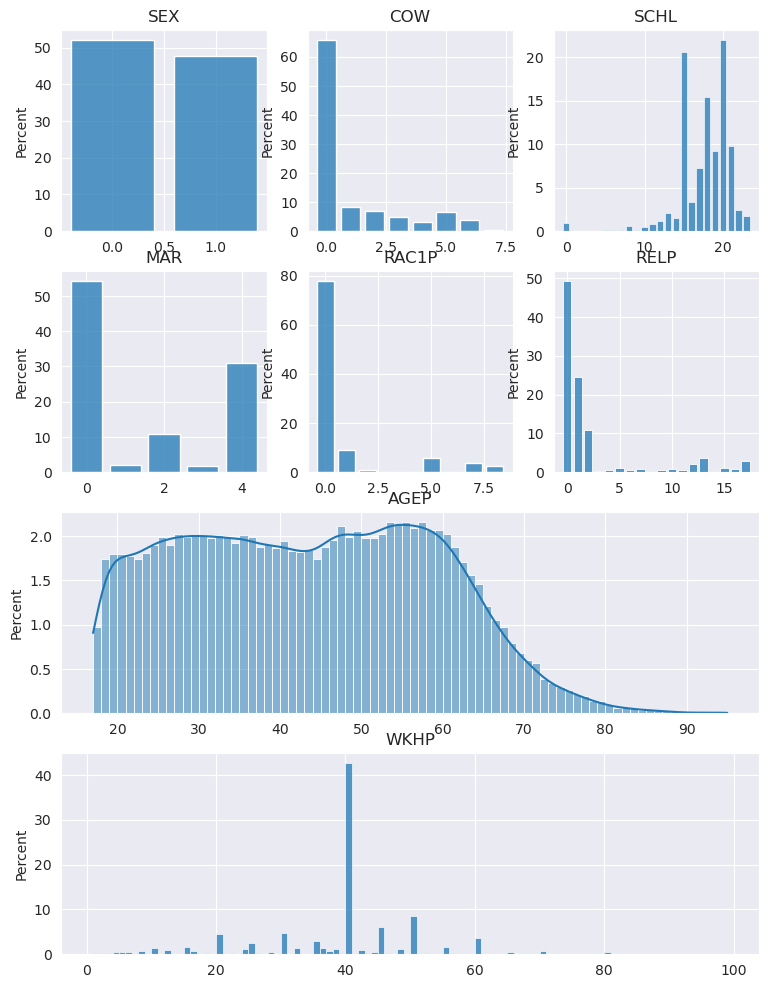

In [25]:
%%capture --no-stdout --no-display
fig, axes = plt.subplot_mosaic(
    [
        ["SEX", "COW", "SCHL"],
        ["MAR", "RAC1P", "RELP"],
        ["AGEP"] * 3,
        ["WKHP"] * 3,
    ],
    figsize=(9, 12)
)
for var in input_space.attribute_names:
    if var in ("AGEP", "WKHP"):
        g = sns.histplot(
            data_df, 
            x=var,
            binwidth=1.0,
            legend=var=="WKHP",
            multiple="dodge",
            kde=var=="AGEP",
            stat="percent",
            ax=axes[var]
        )
    else:
        g = sns.histplot(
            data_df,
            x=var,
            discrete=True,
            shrink=0.8,
            multiple="dodge",
            stat="percent",
            legend=False,
            ax=axes[var]
        )
    g.set(title=var, xlabel=None)


(            SEX       COW      SCHL      WKHP       MAR     RAC1P      RELP  \
 SEX    1.000000 -0.029426  0.077202 -0.195621  0.018803  0.003103 -0.023914   
 COW   -0.029426  1.000000  0.093689 -0.009132 -0.131813 -0.032635 -0.076748   
 SCHL   0.077202  0.093689  1.000000  0.083806 -0.104370 -0.082473 -0.120598   
 WKHP  -0.195621 -0.009132  0.083806  1.000000 -0.150777 -0.014159 -0.118878   
 MAR    0.018803 -0.131813 -0.104370 -0.150777  1.000000  0.057727  0.402105   
 RAC1P  0.003103 -0.032635 -0.082473 -0.014159  0.057727  1.000000  0.048439   
 RELP  -0.023914 -0.076748 -0.120598 -0.118878  0.402105  0.048439  1.000000   
 AGEP  -0.014250  0.194608  0.049917  0.060323 -0.489843 -0.094869 -0.316401   
 
            AGEP  
 SEX   -0.014250  
 COW    0.194608  
 SCHL   0.049917  
 WKHP   0.060323  
 MAR   -0.489843  
 RAC1P -0.094869  
 RELP  -0.316401  
 AGEP   1.000000  ,)

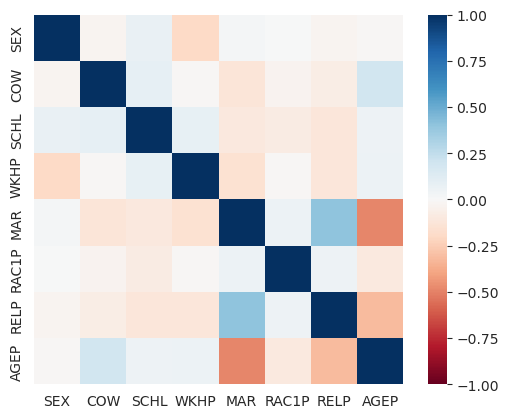

In [26]:
%%capture --no-stdout --no-display
_ = sns.heatmap(
    data_df.corr(),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=data_df.columns,
    yticklabels=data_df.columns,
)
data_df.corr(),


# Population Model
We fit a Bayesian network population model to the whole dataset.
To obtain population models for fewer variables, we just mark the unobserved 
variables as latent. 

The full network structure is:
- Root nodes: `SEX`, `RAC1P`, `AGEP`.
- `SEX, RAC1P -> SCHL`
- `SCHL, AGEP -> MAR`
- `MAR -> RELP`
- `SCHL, MAR -> COW, WKHP`

We introduce broad age groups for `AGEP`.


In [27]:
factory = BayesianNetwork.Factory()


In [28]:
sex = factory.new_node("SEX", replace=True)
sex_size = len(input_space.attribute_values("SEX"))
sex.one_hot_event_space(sex_size)
sex.set_conditional_probability({}, CategoricalOneHot(frequencies["SEX"]))


In [29]:
race = factory.new_node("RAC1P", replace=True)
race_size = len(input_space.attribute_values("RAC1P"))
race.one_hot_event_space(race_size)
race.set_conditional_probability({}, CategoricalOneHot(frequencies["RAC1P"]))


In [30]:
age = factory.new_node("AGEP", replace=True)
age_min, age_max = input_space.attribute_bounds("AGEP")
age.discrete_event_space(*[years for years in range(age_min, age_max+1)])
age_distr = MixtureModel.fit_truncnorm_mixture(
    data_df["AGEP"], 
    bounds=(age_min, age_max), 
    n_components=4, 
    n_init=3, 
    seed=353382635667039
)
age.set_conditional_probability({}, AsInteger.wrap(age_distr))


In [31]:
age_groups = [(17.0, 34.0), (35.0, 59.0), (60.0, 95.0)]


In [32]:
school = factory.new_node("SCHL", replace=True)
school.set_parents(sex, race)

school_size = len(input_space.attribute_values("SCHL"))
school.one_hot_event_space(school_size)

for i in range(sex_size):
    for j in range(race_size):
        sex_matches = dataset.data[:, var_to_col_idx["SEX"][i]].bool()
        race_matches = dataset.data[:, var_to_col_idx["RAC1P"][j]].bool()
        subset = dataset.data[sex_matches & race_matches]
        values = subset[:, var_to_col_idx["SCHL"]]
        if len(subset) > 0:
            freqs = torch.mean(values, dim=0)
        else:
            freqs = frequencies["SCHL"]
        school.set_conditional_probability(
            {
                sex: [float(l == i) for l in range(sex_size)],
                race: [float(l == j) for l in range(race_size)],
            },
            CategoricalOneHot(freqs)
        )


In [33]:
marital_status = factory.new_node("MAR", replace=True)
marital_status.set_parents(school, age)

marital_status_size = len(input_space.attribute_values("MAR"))
marital_status.one_hot_event_space(marital_status_size)

overall_freqs = data_df["MAR"].value_counts(normalize=True, sort=True, ascending=True)
for i in range(school_size):
    for age_group in age_groups:
        low_age, up_age = age_group
        school_matches = dataset.data[:, var_to_col_idx["SCHL"][i]].bool()
        age_data = dataset.data[:, var_to_col_idx["AGEP"][0]]
        age_matches = (low_age <= age_data) & (age_data <= up_age)
        subset = dataset.data[school_matches & age_matches]
        values = subset[:, var_to_col_idx["MAR"]]
        if len(subset) > 0:
            freqs = torch.mean(values, dim=0)
        else:
            freqs = frequencies["MAR"]
        marital_status.set_conditional_probability(
            {
                school: [float(l == i) for l in range(school_size)],
                age: age_group,
            },
            CategoricalOneHot(freqs)
        )


In [34]:
relationship = factory.new_node("RELP", replace=True)
relationship.set_parents(marital_status)

relationship_size = len(input_space.attribute_values("RELP"))
relationship.one_hot_event_space(relationship_size)

overall_freqs = data_df["RELP"].value_counts(normalize=True, sort=True, ascending=True)
for i in range(marital_status_size):
    subset = dataset.data[dataset.data[:, var_to_col_idx["MAR"][i]].bool()]
    values = subset[:, var_to_col_idx["RELP"]]
    if len(subset) > 0:
        freqs = torch.mean(values, dim=0)
    else:
        freqs = frequencies["RELP"]
    relationship.set_conditional_probability(
        {
            marital_status: [float(l == i) for l in range(marital_status_size)],
        },
        CategoricalOneHot(freqs.tolist())
    )


In [35]:
cow = factory.new_node("COW", replace=True)
cow.set_parents(school, marital_status)

cow_size = len(input_space.attribute_values("COW"))
cow.one_hot_event_space(cow_size)

overall_freqs = data_df["COW"].value_counts(normalize=True, sort=True, ascending=True)
for i in range(school_size):
    for j in range(marital_status_size):
        subdata = data_df[(data_df["SCHL"] == i) & (data_df["MAR"] == j)]
        freqs = subdata["COW"].value_counts(normalize=True, sort=True, ascending=True)
        for k in range(cow_size):
            if k not in freqs:
                freqs[k] = 0.0
        if len(subdata) == 0:
            freqs = overall_freqs
        schl_matches = dataset.data[:, var_to_col_idx["SCHL"][i]].bool()
        mar_matches = dataset.data[:, var_to_col_idx["MAR"][j]].bool()
        subset = dataset.data[schl_matches & mar_matches]
        values = subset[:, var_to_col_idx["COW"]]
        if len(subset) > 0:
            freqs = torch.mean(values, dim=0)
        else:
            freqs = frequencies["COW"]
        cow.set_conditional_probability(
            {
                school: [float(l == i) for l in range(school_size)],
                marital_status: [float(l == j) for l in range(marital_status_size)],
            },
            CategoricalOneHot(freqs.tolist())
        )


In [36]:
work_hours = factory.new_node("WKHP", replace=True)
work_hours.set_parents(school, marital_status)

wh_min, wh_max = input_space.attribute_bounds("WKHP")
wh_size = 100
work_hours.discrete_event_space(*[[hours] for hours in range(0, wh_size)])

overall_freqs = data_df["WKHP"].value_counts(normalize=True)
for wh in range(0, wh_size):
    if wh not in overall_freqs:
        overall_freqs[wh] = 0.0
overall_freqs.sort_index(inplace=True)
for i in range(school_size):
    for j in range(marital_status_size):
        subdata = data_df[
            (data_df["SCHL"] == i) & (data_df["MAR"] == j)
        ]
        freqs = subdata["WKHP"].value_counts(normalize=True)
        for wh in range(0, wh_size):
            if wh not in freqs:
                freqs[wh] = 0.0
        if len(subdata) == 0:
            freqs = overall_freqs
        freqs.sort_index(inplace=True)
        work_hours.set_conditional_probability(
            {
                school: [float(l == i) for l in range(school_size)],
                marital_status: [float(l == j) for l in range(marital_status_size)],
            },
            Categorical(freqs.tolist())
        )


In [37]:
bayes_net_vars = tuple(dataset.variables)
factory.reorder_nodes(bayes_net_vars)
bayes_net = factory.create()


# Visualize the Population Model


In [38]:
n = 10000
data_df["dataset"] = "original"

generated_data = bayes_net.sample(n, seed=346024294923158)
generated_raw = {}
subspace_layout = input_space.encoding_layout
for var in input_space.attribute_names:
    cols = subspace_layout[var]
    if isinstance(cols, int):
        generated_raw[var] = generated_data[:, cols]
    else:
        values_one_hot = generated_data[:, list(cols.values())]
        values = np.argmax(values_one_hot, axis=1)
        generated_raw[var] = values

generated_df = pd.DataFrame(generated_raw)
generated_df["dataset"] = "generated"
df = pd.concat([generated_df, data_df])


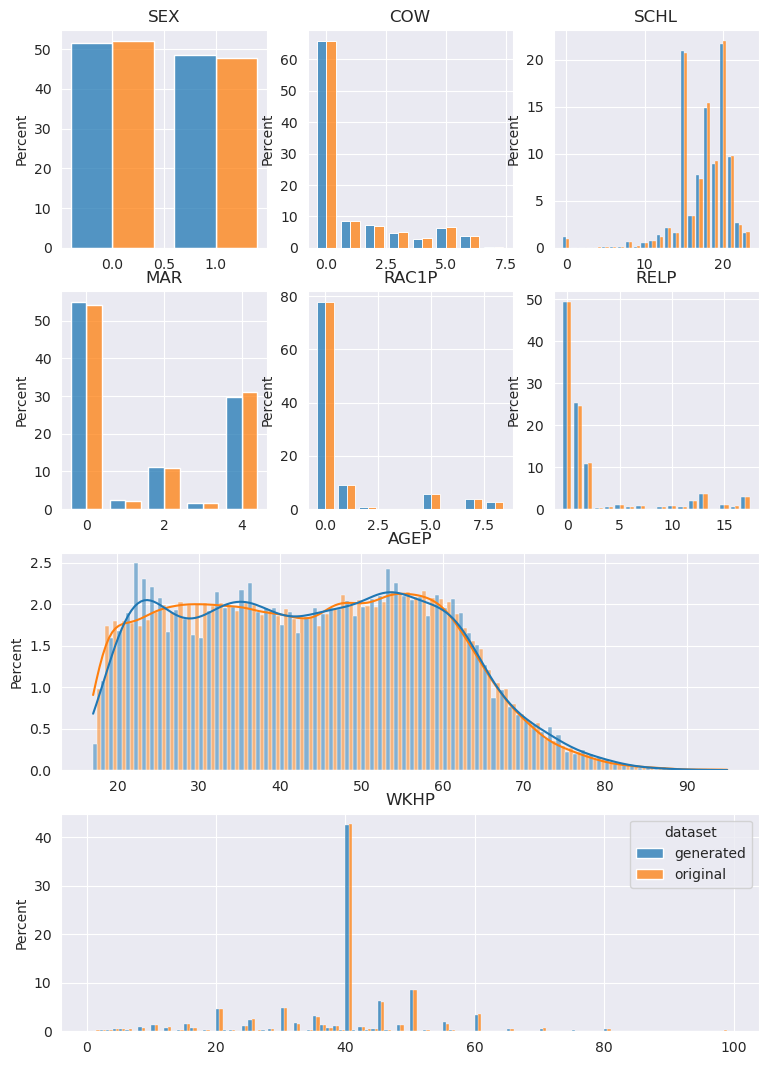

In [39]:
%%capture --no-stdout --no-display
fig, axes = plt.subplot_mosaic(
    [
        ["SEX", "COW", "SCHL"],
        ["MAR", "RAC1P", "RELP"],
        ["AGEP"] * 3,
        ["WKHP"] * 3,
    ],
    figsize=(9, 13)
)
for var in input_space.attribute_names:
    if var in ("AGEP", "WKHP"):
        g = sns.histplot(
            df, 
            x=var,
            hue="dataset",
            binwidth=1.0,
            legend=var=="WKHP",
            multiple="dodge",
            kde=var=="AGEP",
            stat="percent",
            common_norm=False,
            ax=axes[var]
        )
    else:
        g = sns.histplot(
            df,
            x=var,
            hue="dataset",
            discrete=True,
            shrink=0.8,
            multiple="dodge",
            stat="percent",
            legend=False,
            common_norm=False,
            ax=axes[var]
        )
    g.set(title=var, xlabel=None)


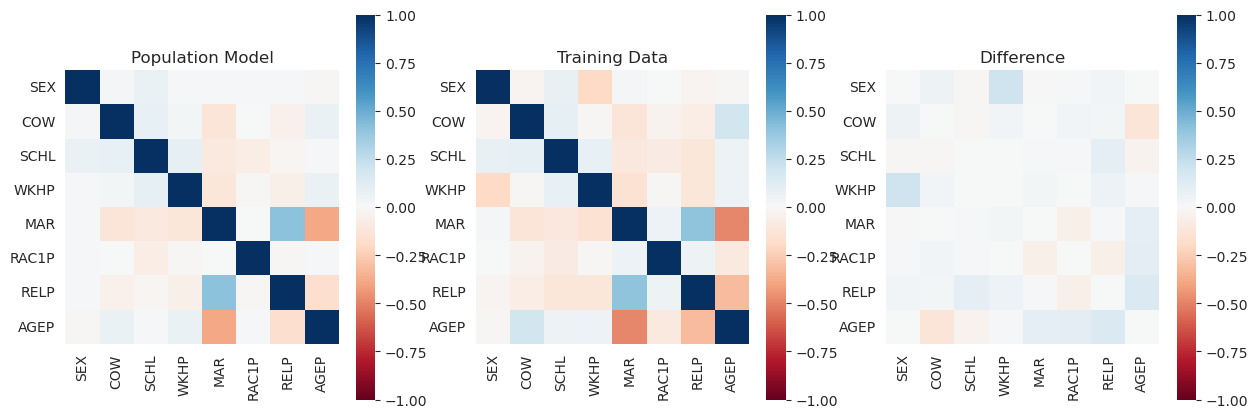

In [40]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

generated_df_ = df[df["dataset"] == "generated"][[var for var in dataset.variables]]
data_df_ = df[df["dataset"] == "original"][[var for var in dataset.variables]]
pop_model_corrcoef = generated_df_.corr()
data_corrcoef = data_df_.corr()
diff = pop_model_corrcoef - data_corrcoef
for corrcoef, ax in zip((pop_model_corrcoef, data_corrcoef, diff), axes):
    _ = sns.heatmap(
        corrcoef,
        vmin=-1.0,
        vmax=1.0,
        square=True,
        cmap="RdBu",
        xticklabels=dataset.variables,
        yticklabels=dataset.variables,
        ax=ax,
    )
_ = axes[0].set_title("Population Model")
_ = axes[1].set_title("Training Data")
_ = axes[2].set_title("Difference")


# Export
Create one Bayesian network + input space for datasets with numbers of features form 1 to 10.
Create smaller Bayesian networks by marking features as hidden.


In [41]:
# create a normalization transformation
# x = (x - mean) / std = x * 1/std - mean * 1/std
means = torch.mean(dataset.data, dim=0)
stds = torch.std(dataset.data, dim=0)

def make_normalize(vars_):
    included_cols = sum((var_to_col_idx[var] for var in vars_), [])
    cols_remap = {}
    i = 0
    for col in included_cols:
        cols_remap[col] = i
        i += 1
    weight = torch.eye(len(included_cols))
    bias = torch.zeros(len(included_cols))

    for var in ("WKHP", "AGEP"):
        if var in vars_:
            col = cols_remap[var_to_col_idx[var][0]]
            weight[col, col] = 1/stds[col]
            bias[col] = -means[col]/stds[col]

    normalize = nn.Linear(weight.size(1), weight.size(0), bias=True)
    with torch.no_grad():
        normalize.weight = nn.Parameter(weight, requires_grad=False)
        normalize.bias = nn.Parameter(bias, requires_grad=False)
    return normalize

make_normalize(all_variables)(dataset.data[:2])


tensor([[ 0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -2.1611,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000, -1.5874],
        [ 0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000, 

In [42]:
nodes = {
    "SEX": sex, "COW": cow, "SCHL": school, "WKHP": work_hours, 
    "MAR": marital_status, "RAC1P": race, "RELP": relationship, "AGEP": age
}
for node in nodes.values():
    node.hidden = False  # if you run this cell multiple times

int_vars = {"WKHP", "AGEP"}
remaining_vars = list(dataset.variables) 
hidden_vars = []
for num_vars in tqdm(reversed(range(0, max_variables)), total=max_variables):
    factory.reorder_nodes(remaining_vars + hidden_vars)
    smaller_bayes_net = factory.create()
    
    smaller_input_space = TabularInputSpace(
        remaining_vars,
        data_types={var: input_space.attribute_type(var) for var in remaining_vars},
        continuous_ranges={},
        integer_ranges={
            var: input_space.attribute_bounds(var) 
            for var in remaining_vars 
            if var in int_vars
        },
        categorical_values={
            var: input_space.attribute_values(var)
            for var in remaining_vars
            if var not in int_vars
        }
    )
    
    smaller_transform = make_normalize(remaining_vars)
    
    torch.save(
        (smaller_bayes_net, smaller_input_space, smaller_transform),
        f"../../resources/MiniACSIncome/bayes_net_{num_vars+1}_var_population_model.pyt",
        pickle_module=dill,
    )

    remove_var = MiniACSIncome.variables_order[num_vars]
    nodes[remove_var].hidden = True
    remaining_vars.remove(remove_var)
    hidden_vars.append(remove_var)


8it [00:41,  5.13s/it]
